# **Text Mining**
Notebook illustartes text mining of the extracted csv file. This notebook is to be read in conjunction with "TWENTY-FIVE YEARS OF EXPLORATIVE SURVEY IN ENERGY DOMAIN FOR FIVE PREMIER ENERGY JOURNALS: A TEXT MINING AND MACHINE LEARNING BASED OVERVIEW"

In [ ]:
import pandas as pd
import numpy as np
import sys
import os

# Libraries for text preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()


from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download a file based on its file ID
journal="Energy"
# CSV file stored on Google Drive
file_id='13--OW3PQ4GMGyTqZBkNvJY1xbTWm_UlY'
download = drive.CreateFile({'id': file_id})
download.GetContentFile('file.csv')
print('Downloaded Data File')

Downloaded Data File


In [ ]:
# Save file to dataframe
dfs = pd.read_csv('file.csv', header=None, names=['Publication','CoverDate', 'Title', 'Keywords','Abstract','PII'], encoding='ISO-8859-1')
#m_corpus = pd.DataFrame()
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19235 entries, 0 to 19234
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Publication  19180 non-null  object
 1   CoverDate    19180 non-null  object
 2   Title        19180 non-null  object
 3   Keywords     17614 non-null  object
 4   Abstract     18975 non-null  object
 5   PII          19230 non-null  object
dtypes: object(6)
memory usage: 901.8+ KB


In [ ]:
#Drop Duplicates
dfs= dfs.drop_duplicates(subset=['PII'])
dfs.reset_index(drop=True, inplace=True)
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19097 entries, 0 to 19096
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Publication  19089 non-null  object
 1   CoverDate    19089 non-null  object
 2   Title        19089 non-null  object
 3   Keywords     17614 non-null  object
 4   Abstract     18887 non-null  object
 5   PII          19096 non-null  object
dtypes: object(6)
memory usage: 895.3+ KB


In [ ]:
# Converting to datetime format
dfs['CoverDate']= pd.to_datetime(dfs['CoverDate'])

In [ ]:
# Not taking papers in year 2021
dfs = dfs[dfs['CoverDate'].dt.year < 2021]
dfs.reset_index(drop=True, inplace=True)
dfs

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Editorial is not covered
# Count Matrix
pd.set_option("display.max_rows", None, "display.max_columns", None)
dfs.groupby([(dfs['CoverDate'].dt.year),(dfs['CoverDate'].dt.month)]).agg(['count'])

Publication CoverDate Title Keywords Abstract   PII
                          count     count count    count    count count
CoverDate CoverDate                                                    
1995      1                   5         5     5        0        5     5
          2                   7         7     7        0        7     6
          3                   7         7     7        0        7     7
          4                   8         8     8        0        8     8
          6                  11        11    11        0       10    11
          7                   9         9     9        0        9     9
          8                  10        10    10        0        8    10
          9                  12        12    12        0       12    12
          10                 13        13    13        0       13    13
          12                 21        21    21        0       21    21
1996      1                   2         2     2        0        2     2
          2                   1         1     1        0        1     1
          3                   1         1     1        0        1     1
          6                   2         2     2        0        2     2
          8                   2         2     2        0        2     2
          12                  1         1     1        0        1     1
1997      1                   9         9     9        0        9     9
          3                  36        36    36        0       35    36
          4                   6         6     6        0        6     6
          5                  13        13    13        0       13    13
          6                   7         7     7        0        7     7
          7                  10        10    10        0       10    10
          8                  11        11    11        0       11    11
          9                   8         8     8        0        8     8
          10                  9         9     9        0        9     9
          11                 10        10    10        0       10    10
          12                  8         8     8        0        8     8
1998      1                   9         9     9        0        8     9
          2                   9         9     9        0        9     9
          3                   8         8     8        0        8     8
          4                   8         8     8        0        8     8
          5                  11        11    11        0       11    11
          6                   9         9     9        0        8     9
          7                  12        12    12        0       11    12
          9                  11        11    11        0       11    11
          10                 11        11    11        0       10    11
          11                 11        11    11        0       10    11
          12                 13        13    13        0       13    13
1999      1                  13        13    13        0       12    13
          2                   9         9     9        0        9     9
          3                   8         8     8        0        8     8
          4                   8         8     8        0        8     8
          5                   8         8     8        1        8     8
          6                   8         8     8        2        8     8
          7                   7         7     7        1        7     7
          8                   7         7     7        0        7     7
          9                   5         5     5        0        5     5
          10                  6         6     6        0        6     6
          11                  6         6     6        0        6     6
2000      1                   7         7     7        0        7     7
          2                   5         5     5        0        5     5
          3                   6         6     6        0        6     6
          4                   7         7     7        0    

Total Number of Journals Covered: 18151


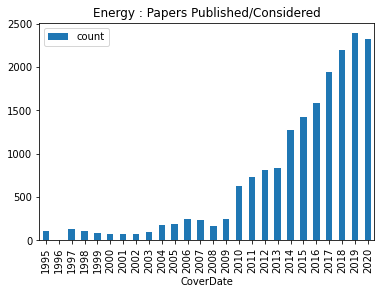

In [ ]:
# Plot of Number of papers published year wise [Editorials are not covered]
ax = dfs.groupby([dfs['CoverDate'].dt.year])['Publication'].agg(['count']).plot.bar(title=journal + ' : Papers Published/Considered')

print("Total Number of Journals Covered:", len(dfs))

**Keyword + Title (Abdrigement) Analysis**

In [1]:
# Generate Word Clouds
def generate_wordcloud(corpus):
  % matplotlib inline
  wordcloud = WordCloud(
                          background_color='white',
                          stopwords = stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
  print(wordcloud)
  fig = plt.figure(1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
  #wordcloud.to_file('wordcloud.png')
  plt.clf()

In [ ]:
#Creating the abdridgement. 
keyword_corpus_time = pd.DataFrame()
keyword_corpus_time['CoverDate'] = dfs['CoverDate']
dfs['Keywords'] = dfs['Keywords'].fillna(' ')
keyword_corpus_time['Keywords'] = dfs['Keywords'] + ',' + dfs['Title']

# Please note that "Keywords" referenced indicates "Keywords"+"Title" (i.e. abrigement) from this section

#keyword_corpus_time.dropna(inplace=True)
keyword_corpus_time.reset_index(drop=True, inplace=True)
keyword_corpus_time['CoverDate']= pd.to_datetime(keyword_corpus_time['CoverDate'])
keyword_corpus_time

Output hidden; open in https://colab.research.google.com to view.

Total Number of Journals Covered: 11302


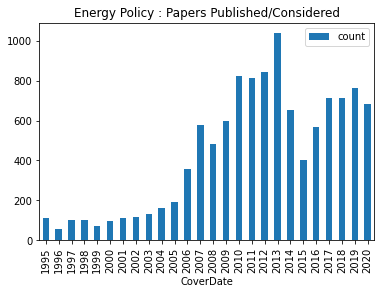

In [ ]:
# Plot of Number of papers published year wise [Editorials are not covered]
ax = keyword_corpus_time.groupby([keyword_corpus_time['CoverDate'].dt.year])['CoverDate'].agg(['count']).plot.bar(fill=True,title=journal + ' : Papers Published/Considered')
print("Total Number of Journals Covered:", len(keyword_corpus_time))

In [ ]:
# Splitting keywords
def split_keywords(corpus):

  split_corpus=[]

  for i in range(len(corpus)):
    list_k = corpus['Keywords'][i].split(",")
    split_corpus += list_k

  return split_corpus

In [ ]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))

##Creating a list of custom stopwords
new_words = ["energy","based","multi","using"]
stop_words = stop_words.union(new_words)

In [ ]:
# Preprocessing a string 
def preprocess(str) :
  #Remove punctuations
    text = re.sub('[^a-zA-Z0-9]', ' ', str)
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters
    text=re.sub("(\\W)+"," ",text)

    if text in stop_words:
      return None

    return text

In [ ]:
# For calculating frequency plots
def freq_time(keyword_corpus_time, start, end):

  keyword_corpus = keyword_corpus_time[(keyword_corpus_time['CoverDate'] >= start) & (keyword_corpus_time['CoverDate'] < end)]
  number_of_articles = len(keyword_corpus['Keywords'])
  #Split Keywords
  split_corpus=[]

  for i in range(len(keyword_corpus)):
    list_k = re.split(', | " " ', keyword_corpus['Keywords'].iloc[i])
    split_corpus += list_k
   
      

  prpr_corpus = []
  for word in split_corpus:
    text = preprocess(word) 
    if text is not None:
      prpr_corpus.append(text)
  
  vec = CountVectorizer().fit(prpr_corpus)
  bag_of_words = vec.transform(prpr_corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items() if not word in  stop_words]
  words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)

  return words_freq, number_of_articles, prpr_corpus

In [ ]:
# For plotting top keywords
def plot_topwords(words_freq):
  top_words = words_freq[:20]
  top_df = pd.DataFrame(top_words)
  top_df.columns=["Word", "Freq"]
  sns.set(rc={'figure.figsize':(13,8)})
  g = sns.barplot(x="Word", y="Freq", data=top_df)
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
  g.set_title(journal + ' : Top Words occuring in keywords')
  plt.figure()

In [ ]:
words_freq, number_of_articles, prpr_corpus = freq_time(keyword_corpus_time,'1994','2021')

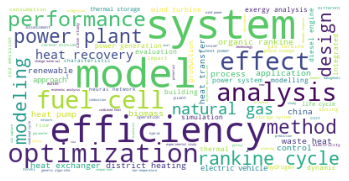

<Figure size 432x288 with 0 Axes>

In [ ]:
# World Cloud of Entire Corpus
generate_wordcloud(prpr_corpus)

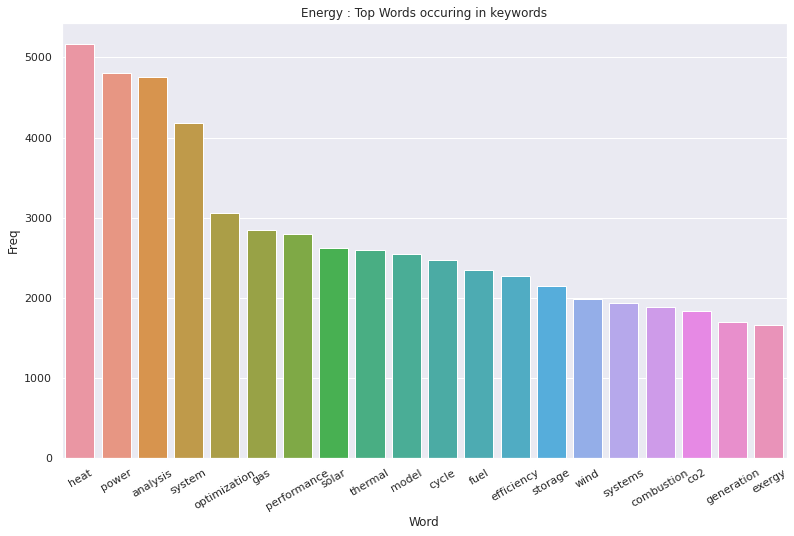

<Figure size 936x576 with 0 Axes>

In [ ]:
plot_topwords(words_freq)

In [ ]:
# To words as a list
top_words = words_freq[:20]
list_top_words=[]
for word,_ in top_words:
  list_top_words.append(word)
list_top_words

['heat',
 'power',
 'analysis',
 'system',
 'optimization',
 'gas',
 'performance',
 'solar',
 'thermal',
 'model',
 'cycle',
 'fuel',
 'efficiency',
 'storage',
 'wind',
 'systems',
 'combustion',
 'co2',
 'generation',
 'exergy']

In [ ]:
dftagword=pd.DataFrame(columns=['Year','NoofArticles','Words_f'])
for i in range(1995,2021):
  start=str(i)
  end=str(i+1)
  words_freq, number_of_articles,_ = freq_time(keyword_corpus_time,start,end)
  dftagword = dftagword.append({'Year':start, 'NoofArticles': number_of_articles, 'Words_f':words_freq},ignore_index=True)
dftagword

,Year,NoofArticles,Words_f
0,1995,103,"[(solar, 16), (power, 11), (heat, 11), (use, 1..."
1,1996,9,"[(residential, 3), (heat, 3), (analysis, 2), (..."
2,1997,127,"[(co2, 35), (system, 17), (solar, 16), (gas, 1..."
3,1998,112,"[(analysis, 13), (solar, 11), (system, 11), (a..."
4,1999,85,"[(solar, 12), (analysis, 11), (air, 8), (syste..."
5,2000,76,"[(heat, 15), (analysis, 12), (systems, 11), (s..."
6,2001,78,"[(analysis, 11), (electricity, 9), (fuel, 7), ..."
7,2002,73,"[(power, 10), (solar, 9), (efficiency, 7), (sy..."
8,2003,92,"[(power, 10), (systems, 10), (solar, 10), (stu..."
9,2004,172,"[(co2, 37), (analysis, 27), (power, 26), (sola..."


In [ ]:
# Frequency of a word year wise
def freq_word_year(word):
  dfword=pd.DataFrame()
  for i in range(len(dftagword)) :
    try:
      countofkeyword = dict(dftagword['Words_f'][i])[word]
    except:
      countofkeyword = 0

    noofpapers = dftagword['NoofArticles'][i]
    count = countofkeyword
    prop = count / noofpapers 
    nprop = 'prop' + word
    year = dftagword['Year'][i]
    dfword = dfword.append({'Year':year, word: count, nprop: prop,'Tot':noofpapers},ignore_index=True)
  return dfword

In [ ]:
# Frequency of a word-  
# word='solar'
word='covid'
dfword = freq_word_year(word)

<Figure size 936x576 with 0 Axes>

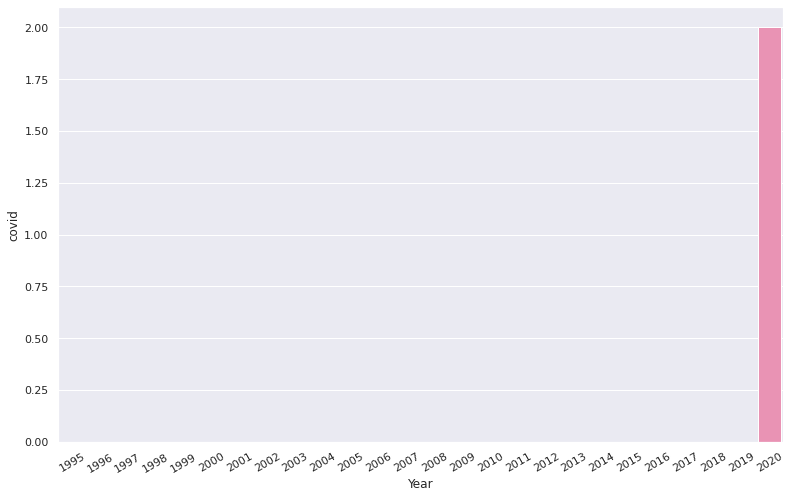

<Figure size 936x576 with 0 Axes>

In [ ]:
 # Plotting 
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Year", y= word, data=dfword)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.figure()

In [ ]:
# Tracking evolution of top key words
df_tot=pd.DataFrame()
for word in list_top_words:
  dfword = freq_word_year(word)
  df_tot[word]=dfword[word]
df_tot['Year'] =dfword['Year']

In [ ]:
df_tot = df_tot.set_index('Year')
df_tot

,heat,power,analysis,system,optimization,gas,performance,solar,thermal,model,cycle,fuel,efficiency,storage,wind,systems,combustion,co2,generation,exergy
Year,,,,,,,,,,,,,,,,,,,,
1995,11.0,11.0,10.0,7.0,5.0,3.0,8.0,16.0,3.0,3.0,9.0,2.0,7.0,3.0,0.0,4.0,5.0,1.0,1.0,0.0
1996,3.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1997,12.0,12.0,11.0,17.0,2.0,16.0,7.0,16.0,6.0,7.0,7.0,5.0,9.0,3.0,2.0,12.0,6.0,35.0,1.0,4.0
1998,7.0,6.0,13.0,11.0,5.0,8.0,3.0,11.0,7.0,4.0,2.0,1.0,2.0,2.0,0.0,2.0,1.0,4.0,4.0,7.0
1999,7.0,7.0,11.0,8.0,5.0,5.0,2.0,12.0,2.0,3.0,4.0,3.0,4.0,2.0,4.0,4.0,2.0,4.0,4.0,1.0
2000,15.0,7.0,12.0,7.0,3.0,6.0,5.0,11.0,5.0,4.0,6.0,3.0,3.0,4.0,2.0,11.0,2.0,5.0,3.0,3.0
2001,4.0,4.0,11.0,6.0,3.0,4.0,4.0,6.0,3.0,4.0,5.0,7.0,6.0,0.0,0.0,2.0,2.0,2.0,1.0,3.0
2002,6.0,10.0,3.0,7.0,4.0,3.0,7.0,9.0,7.0,3.0,2.0,2.0,7.0,3.0,4.0,2.0,3.0,5.0,5.0,3.0
2003,8.0,10.0,6.0,7.0,3.0,8.0,4.0,10.0,5.0,2.0,6.0,4.0,8.0,2.0,2.0,10.0,0.0,5.0,4.0,8.0


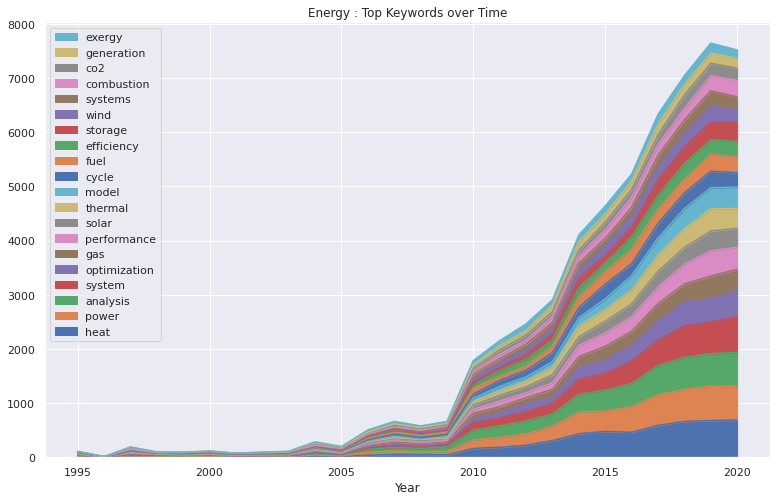

In [ ]:
# Plotting top keywords
ax= df_tot.plot.area(title=journal + ' : Top Keywords over Time')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

In [ ]:
# Normalization of frequency over time charts
df_tot_new = df_tot.div(df_tot['sum'],axis=0)
df_tot_new.drop(columns='sum', inplace=True)
df_tot_new

,heat,power,analysis,system,optimization,gas,performance,solar,thermal,model,cycle,fuel,efficiency,storage,wind,systems,combustion,co2,generation,exergy
Year,,,,,,,,,,,,,,,,,,,,
1995,0.100917,0.100917,0.091743,0.064220,0.045872,0.027523,0.073394,0.146789,0.027523,0.027523,0.082569,0.018349,0.064220,0.027523,0.000000,0.036697,0.045872,0.009174,0.009174,0.000000
1996,0.272727,0.000000,0.181818,0.090909,0.000000,0.000000,0.090909,0.000000,0.090909,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000
1997,0.063158,0.063158,0.057895,0.089474,0.010526,0.084211,0.036842,0.084211,0.031579,0.036842,0.036842,0.026316,0.047368,0.015789,0.010526,0.063158,0.031579,0.184211,0.005263,0.021053
1998,0.070000,0.060000,0.130000,0.110000,0.050000,0.080000,0.030000,0.110000,0.070000,0.040000,0.020000,0.010000,0.020000,0.020000,0.000000,0.020000,0.010000,0.040000,0.040000,0.070000
1999,0.074468,0.074468,0.117021,0.085106,0.053191,0.053191,0.021277,0.127660,0.021277,0.031915,0.042553,0.031915,0.042553,0.021277,0.042553,0.042553,0.021277,0.042553,0.042553,0.010638
2000,0.128205,0.059829,0.102564,0.059829,0.025641,0.051282,0.042735,0.094017,0.042735,0.034188,0.051282,0.025641,0.025641,0.034188,0.017094,0.094017,0.017094,0.042735,0.025641,0.025641
2001,0.051948,0.051948,0.142857,0.077922,0.038961,0.051948,0.051948,0.077922,0.038961,0.051948,0.064935,0.090909,0.077922,0.000000,0.000000,0.025974,0.025974,0.025974,0.012987,0.038961
2002,0.063158,0.105263,0.031579,0.073684,0.042105,0.031579,0.073684,0.094737,0.073684,0.031579,0.021053,0.021053,0.073684,0.031579,0.042105,0.021053,0.031579,0.052632,0.052632,0.031579
2003,0.071429,0.089286,0.053571,0.062500,0.026786,0.071429,0.035714,0.089286,0.044643,0.017857,0.053571,0.035714,0.071429,0.017857,0.017857,0.089286,0.000000,0.044643,0.035714,0.071429


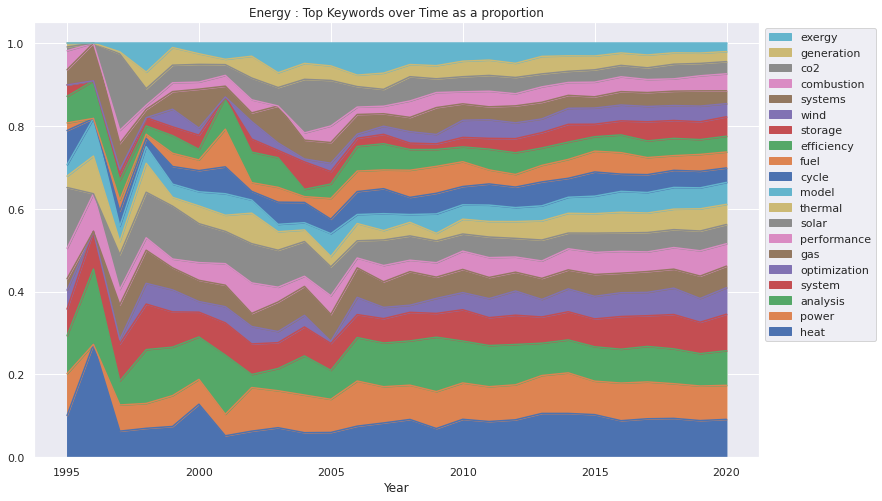

In [ ]:
ax = df_tot_new.plot.area(title=journal + ' : Top Keywords over Time as a proportion')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=(1, 1))